In [10]:
import tensorflow as tf
import tensorflow.keras.layers as tfl
import os
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.datasets import cifar10
train_ds, test_ds = cifar10.load_data()

# Split the training set into training and validation sets
split = int(train_ds[0].shape[0] * 0.8)
train_ds, val_ds = (
    (train_ds[0][:split], train_ds[1][:split]),
    (train_ds[0][split:], train_ds[1][split:])
)

# Data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tfl.Rescaling(1./255),
    tfl.RandomFlip(mode="horizontal"),
    tfl.RandomRotation(factor=0.1),
    tfl.RandomContrast(factor=(0.2, 0.9)),
    tfl.RandomZoom(height_factor=(0.1, 0.3))
])

# Preprocessing function
def preprocess(x, y):
    return data_augmentation(x), tf.one_hot(tf.squeeze(y), 10)

# Create tf.data.Dataset objects
train_ds = tf.data.Dataset.from_tensor_slices(train_ds).map(preprocess).batch(64)
val_ds = tf.data.Dataset.from_tensor_slices(val_ds).map(preprocess).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices(test_ds).map(preprocess).batch(64)
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [3]:
base_model = tf.keras.applications.VGG19(include_top=False,weights =
"imagenet",input_shape=(32,32,3))
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [4]:
for layer in base_model.layers[:-5]:
    layer.trainable=False
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [5]:
model = tf.keras.Sequential([
    base_model,
    tfl.Flatten(),
    tfl.Dense(256,activation="relu"),
    tfl.Dense(128,activation="relu"),
    tfl.Dense(64,activation="relu"),
    tfl.Dense(10,activation ="softmax")
])
model.summary( )


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 20,197,514
Trainable params: 9,612,362
N

In [6]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy( ),
    metrics=['accuracy']
    )
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=1,
    callbacks=[
    tf.keras.callbacks.TensorBoard(log_dir="logs")
]
)


625/625 [==============================] - 554s 882ms/step - loss: 1.7254 - accuracy: 0.3499 - val_loss: 1.4424 - val_accuracy: 0.4899


In [7]:
%load_ext tensorboard
%tensorboard --logdir logs


Reusing TensorBoard on port 6006 (pid 9228), started 20 days, 17:46:41 ago. (Use '!kill 9228' to kill it.)

In [8]:
loss,accuracy = model.evaluate(test_ds)
print("Loss:",loss)
print("Accuracy:",accuracy)

157/157 [==============================] - 20s 127ms/step - loss: 1.4311 - accuracy: 0.4904
Loss: 1.4310834407806396
Accuracy: 0.4903999865055084


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


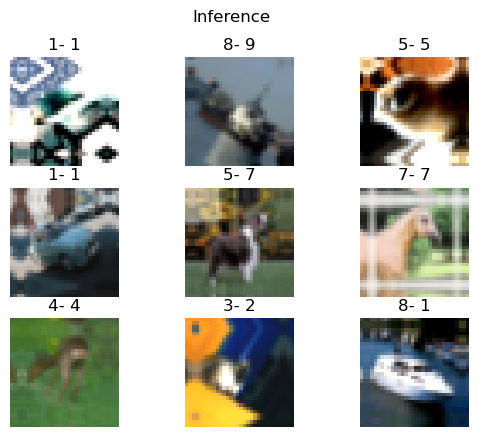

In [11]:
image, label = next(iter(val_ds))
images = image.numpy()[:9]
res = tf.argmax(model(image),axis=-1)
plt.suptitle("Inference")
for i,(img,r) in enumerate(zip(images, res)):
    plt.subplot(331+i)
    plt.title(f"{tf.argmax(label[i])}- {res[i]}")
    plt.imshow(img)
    plt.axis("off")
plt.show()
